 <h1><center> Quel(le) data scientist êtes-vous ?  </center></h1>     
 
 
 
## Contexte de l’analyse

Elu métier le plus sexy par la Harvard Business Review en octobre 2012, le data scientist représente un profil rare qui exige de nombreuses compétences.

A partir d'un dataset "data", vous réaliserez :
- un clustering non supervisé afin d'identifier 2 groupes de profils techniques distinctes
- une prédiction des profils dont le métier n'est pas labellisé


## Données
data.csv contient 6 variables : 
    - 'Entreprise' correspond à une liste d'entreprises fictive
    - 'Metier' correspond au métier parmi data scientist, lead data scientist, data engineer et data architecte
    - 'Technologies' correspond aux compétences maîtrisées par le profil
    - 'Diplome' correspond à son niveau scolaire (Bac, Master, PhD,...)
    - 'Experience' correspond au nombre d'années d'expériences
    - 'Ville' correspond au lieu de travail
    


## Répondez aux questions 

Bonne chance!

In [1]:
# Import des libraries classique (numpy, pandas, ...)
import pandas as pd
import numpy as np
import re
import sklearn as sk
import seaborn as sb
from matplotlib import pyplot as plt
plt.style.use('ggplot')
# =============Import supplementaire from sklearn=================
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix


### 1) Importer le tableau de données dans un dataframe 

In [2]:
# Import du dataframe "data.csv"
df = pd.read_csv("data.csv")
df.head()

,Entreprise,Metier,Technologies,Diplome,Experience,Ville
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1,Paris
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3,Marseille
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3,Nantes
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,"1,5",Marseille
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,NaN,Bordeaux


Nous cherchons à savoir les informations sur les données

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9582 entries, 0 to 9581
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Entreprise    9565 non-null   object
 1   Metier        9563 non-null   object
 2   Technologies  9582 non-null   object
 3   Diplome       9582 non-null   object
 4   Experience    9488 non-null   object
 5   Ville         9582 non-null   object
dtypes: object(6)
memory usage: 449.3+ KB


Toutes nos features sont de type 'objets'. Nous remarquons aussi la présence de 'Nan value'

### 2) Combien y a t-il d'observations dans ce dataset? Y a t-il des valeurs manquantes? 

In [4]:
# Nombre d'observations dans le dataset
nombre_obs = df.shape[0]
nombre_nan_value = np.sum(df.isnull().sum())
print()
print(f"Le nombre d'observation est de :  {nombre_obs}.")
print()
# Nombre de valeurs manquantes dans le dataset
print(f"Le nombre de valeurs manquantes est : {nombre_nan_value}.")
print()
# Nombre de valeurs manquantes par feature
print("Pour plus de détails sur le nombre de valeurs manquantes, pour chaque feature on a : ")
df.isnull().sum()


Le nombre d'observation est de :  9582.

Le nombre de valeurs manquantes est : 130.

Pour plus de détails sur le nombre de valeurs manquantes, pour chaque feature on a : 


Entreprise      17
Metier          19
Technologies     0
Diplome          0
Experience      94
Ville            0
dtype: int64

### 3) Réaliser l'imputation des valeurs manquantes pour la variable "Experience" avec : 
- la valeur médiane pour les data scientists
- la valeur moyenne pour les data engineers

In [5]:
# Convertion de la variable "Experience" de type objet à type float
df["Experience"] = df["Experience"].str.replace(',', '.', regex = False).astype(float)
df["Experience"].dtype

dtype('float64')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9582 entries, 0 to 9581
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Entreprise    9565 non-null   object 
 1   Metier        9563 non-null   object 
 2   Technologies  9582 non-null   object 
 3   Diplome       9582 non-null   object 
 4   Experience    9488 non-null   float64
 5   Ville         9582 non-null   object 
dtypes: float64(1), object(5)
memory usage: 449.3+ KB


In [7]:
# index ou des valeurs manquantes pour la la variable "Experiience"
indices_Nan_Experience = df.loc[pd.isna(df["Experience"]), :].index
indices_Nan_Experience

Int64Index([   4,   28,  104,  161,  451,  599,  800, 1122, 1150, 1251, 1256,
            1333, 1373, 1507, 1759, 1794, 2085, 2485, 2498, 2545, 2568, 2648,
            2649, 2852, 2870, 2967, 3077, 3236, 3276, 3484, 3801, 3828, 3871,
            3883, 3907, 4016, 4125, 4323, 4333, 4468, 4488, 4658, 4686, 4782,
            4838, 4881, 5095, 5119, 5455, 5551, 5708, 5723, 5762, 5845, 5904,
            5941, 6052, 6055, 6106, 6324, 6335, 6351, 6358, 6624, 6634, 6675,
            6781, 6784, 6805, 7009, 7322, 7451, 7676, 7694, 7695, 7743, 7959,
            8115, 8216, 8276, 8404, 8564, 8574, 8628, 8645, 8668, 8684, 8966,
            9153, 9296, 9496, 9498, 9510, 9512],
           dtype='int64')

In [8]:
# Vérification des métiers concernés par des valeurs manquantes
pd.Series(df.loc[indices_Nan_Experience,"Metier"]).value_counts()

Data scientist         32
Data architecte        23
Data engineer          20
Lead data scientist    19
Name: Metier, dtype: int64

On constate que les tous les métiers (Data scientit, Lead data scientist, Data engineer et Data architecte) sont concernés par les valeurs manquantes et non seulement les Data scientist et Data engineers. On a :

a. 32 valeurs manquantes pour le métier de Data scientist

b. 23 valeurs manquantes pour le métier de Data architecte

c. 20 valeurs manquantes pour le métier de Data engineer

d. 19 valeurs manquantes pour le métier de Lead data scientist

Je propose Réaliser l'imputation des valeurs manquantes pour la variable "Experience" avec :

1. la valeur médiane pour les ds (data scientists)

2. la valeur médiane pour les (lds) Lead data scientists

3. la valeur moyenne pour les (de) data engineers

4. la valeur moyenne pour les (da) Data architecte

In [9]:
# Imputation des valeurs manquantes pour la variable "Experience" avec la moyenne pour les data scientists
ds_nan_mask = df['Metier'] == 'Data scientist'
sd_median = df[ds_nan_mask]['Experience'].dropna().median()
df.loc[ds_nan_mask, 'Experience'] = df.loc[ds_nan_mask, 'Experience'].fillna(sd_median)

# Imputation des valeurs manquantes pour la variable "Experience" avec la moyenne pour les Lead data scientists
lds_nan_mask = df['Metier'] == 'Lead data scientist'
lds_median = df[lds_nan_mask]['Experience'].dropna().median()
df.loc[lds_nan_mask, 'Experience'] = df.loc[lds_nan_mask, 'Experience'].fillna(lds_median)

# Imputation des valeurs manquantes pour la variable "Experience" avec la moyenne pour les data engineers
de_nan_mask = df['Metier'] == 'Data engineer'
de_mean = df[de_nan_mask]['Experience'].dropna().mean()
df.loc[de_nan_mask, 'Experience'] = df.loc[de_nan_mask, 'Experience'].fillna(de_mean)

# Imputation des valeurs manquantes pour la variable "Experience" avec la moyenne pour les Data architechtes
da_nan_mask = df['Metier'] == 'Data architecte'
da_mean = df[da_nan_mask]['Experience'].dropna().mean()
df.loc[da_nan_mask, 'Experience'] = df.loc[da_nan_mask, 'Experience'].fillna(da_mean)

Vérifions qu'il n'y a plus de Nan value pour la variable "Experience":

In [10]:
df['Experience'].isnull().sum()

0

###### Commentaire: Il est à noter qu'il y a d'autres méthode d'imputation pour les valeurs manquantes. 

### 4) Combien d'années d'expériences ont, en moyenne, chacun des profils : le data scientist, le lead data scientist et le data engineer en moyenne?

In [11]:
moyenne_experience_par_metier = df.groupby("Metier").agg({'Experience':'mean'}).reset_index()
moyenne_experience_par_metier = moyenne_experience_par_metier.rename({'Experience':'moyenne_exp'}, axis =1)
moyenne_experience_par_metier_reponse_exact = moyenne_experience_par_metier.drop([moyenne_experience_par_metier.index[0]])
print("Le nombre d'années d'expérience en moyenne de chacun des profils demandés est :")
moyenne_experience_par_metier_reponse_exact

Le nombre d'années d'expérience en moyenne de chacun des profils demandés est :


,Metier,moyenne_exp
1,Data engineer,2.984959
2,Data scientist,2.241268
3,Lead data scientist,3.958062


##### Commentaire

Voici ci-dessous le nombre moyen d'années d'expériences pour chaque métier: 

In [12]:
moyenne_experience_par_metier

,Metier,moyenne_exp
0,Data architecte,3.000476
1,Data engineer,2.984959
2,Data scientist,2.241268
3,Lead data scientist,3.958062


### 5) Faire la représentation graphique de votre choix afin de comparer le nombre moyen d'années d'expériences pour chaque métier

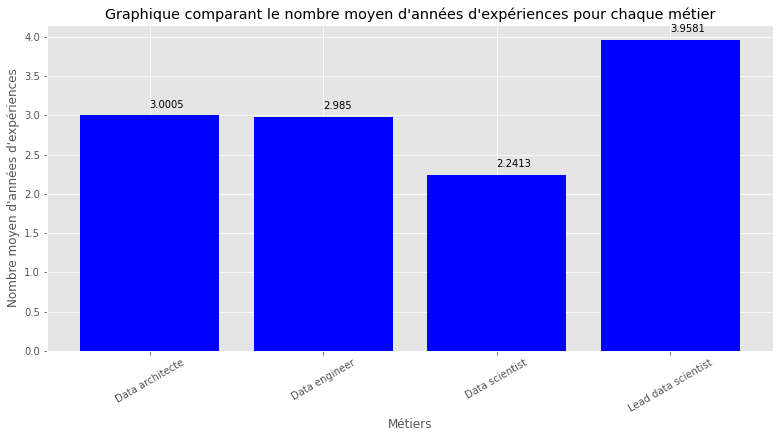

In [13]:
# Taille de la figure
fig, ax = plt.subplots(figsize = (13, 6))

# création du graphique en bar
ax.bar(moyenne_experience_par_metier['Metier'], moyenne_experience_par_metier['moyenne_exp'], color='blue')

# ajout du titre et des étiquettes d'axe
plt.xlabel("Métiers")
plt.ylabel("Nombre moyen d'années d'expériences")
plt.title("Graphique comparant le nombre moyen d'années d'expériences pour chaque métier")

# Ajout du nombre moyen d'années d'expérience sur les barres 
for i in range(len(moyenne_experience_par_metier['Metier'])):
    plt.text(i,moyenne_experience_par_metier['moyenne_exp'][i]+0.1,round(moyenne_experience_par_metier['moyenne_exp'][i],4))
plt.xticks(rotation=30)
plt.show()

### 6) Transformer la variable continue 'Experience' en une nouvelle variable catégorielle 'Exp_label' à 4 modalités: débutant, confirmé, avancé et expert
- Veuillez expliquer votre choix du règle de transformation.  

La répartition des métiers en termes de niveau d'expérience peut varier en fonction de plusieurs facteurs tels que le secteur d'activité, le pays, la taille de l'entreprise, les compétences spécifiques requises, etc. Cependant, voici une estimation générale basée sur les observations du marché pour les data scientists selon google:

1. Débutant : moins de 2 ans d'expérience

2. Confirmé : de 2 à 5 ans d'expérience

3. Avancé : de 5 à 10 ans d'expérience

4. Expert : plus de 10 ans d'expérience


In [14]:
# fonction pour transformer la variable continue en variable catégorielle
def categoriser_exp(exp):
    if exp < 2:
        return 'Débutant'
    elif exp <= 5:
        return 'Confirmé'
    elif exp <= 10:
        return 'Avancé'
    else:
        return 'Expert'

# application de la fonction à la colonne "Experience"
df["Exp_label"] = df['Experience'].apply(categoriser_exp)

Je visualise cette nouvelle variable 

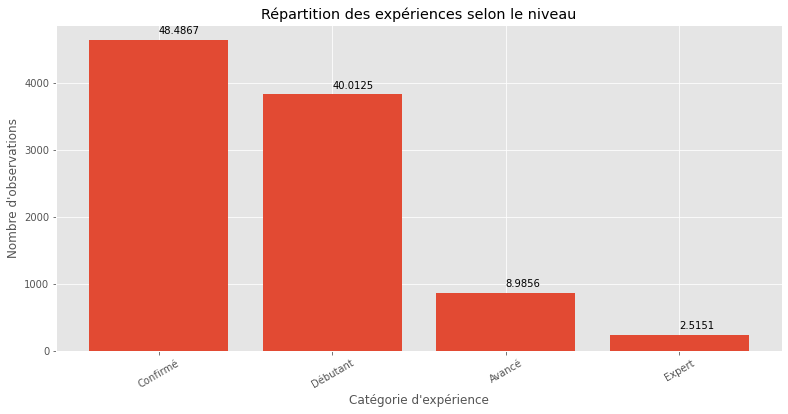

In [15]:
# Taille de la figure
fig, ax = plt.subplots(figsize = (13, 6))

# comptage du nombre d'observations dans chaque catégorie
count = df["Exp_label"].value_counts()

# création du graphique en bar
plt.bar(count.index, count.values)

# ajout du titre et des étiquettes d'axe
plt.xlabel('Catégorie d\'expérience')
plt.ylabel('Nombre d\'observations')
plt.title('Répartition des expériences selon le niveau')

# Ajout du nombre d'employés sur les barres
for i in range(len(count.index)):
    plt.text(i,count.values[i]+90,round((count.values[i]/count.sum())*100,4))
plt.xticks(rotation=30);

# affichage du graphique
plt.show()

### 7) Quelles sont les 5 technologies les plus utilisées? Faites un graphique

Top 5 des technologies les plus utilisées

In [16]:
# Extraction et rangement des technologies 
ensemble_de_technologies = []
for idx,row in df.iterrows():
    r = row["Technologies"].split("/")
    ensemble_de_technologies += r 
    
# comptage du nombre d'occurrences de chaque élément
counts_techno = (pd.Series(ensemble_de_technologies)).value_counts()

# sélection des 5 éléments les plus fréquents
top_five_techno = counts_techno.nlargest(5)
top_five_techno

Python    6627
R         4374
SQL       2581
Java      1719
Hadoop    1589
dtype: int64

In [17]:
# Les technologies utilisées
Techno_used =list(pd.Series(ensemble_de_technologies).unique())
print(Techno_used)

['Matlab', 'Python', 'Pyspark', 'Scikit-learn', 'Tensorflow', 'Java', 'Scala', 'MongoDB', 'SPSS', 'SQL', 'Teradata', 'R', 'scikit-learn', 'C', 'C++', 'numpy', 'VBA', 'Excel', 'PySpark', 'Linux', 'Docker', 'GNU', 'Hadoop', 'Hive', 'MariaDB', 'machine learning', 'Spark', 'AWS', 'Deep learning', 'PostgreSQL', 'Elasticsearch', 'Kibana', 'HDFS', 'Yarn', 'Microsoft Azure', 'Redshift', 'SAS', 'Machine learning', 'Anglais', 'anglais', 'AI', 'Scoring', 'Perl', 'Ruby', 'Pycharm', 'Vertica', 'Tableau', '', 'Big data', 'Kafka', 'ORACLE', 'MySQL', 'Cassandra', 'NoSQL', 'Matplotlib', 'Map-Reduce', 'PIG', 'HBASE', 'Windows', 'NoSQ', 'Hadoop(HDFS)']


In [18]:
# Le nombre de technologies différentes 
nbr = pd.Series(Techno_used).nunique()
print(f"Le nombre de technologies différentes est de : {nbr} ")

Le nombre de technologies différentes est de : 61 


Graphique pour les 5 technologies les plus utilisées

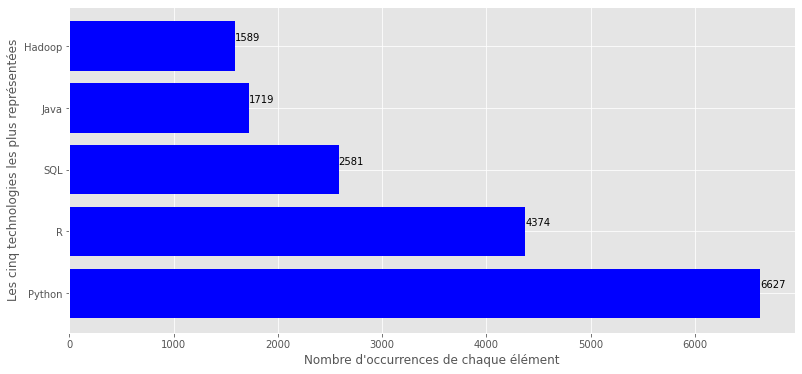

In [19]:
# Taille de la figure
fig, ax = plt.subplots(figsize = (13, 6))

# création du graphique en bar
plt.barh(top_five_techno.index, top_five_techno.values, color = 'blue')

# ajout du titre et des étiquettes d'axe
plt.ylabel("Les cinq technologies les plus représentées")
plt.xlabel("Nombre d'occurrences de chaque élément")
#plt.title('Répartition des des cinq technologies les plus utilisées')

# Ajout du nombre d'employés sur les barres
for i, v in enumerate(top_five_techno.values):
    plt.text(v, i+.09, str(v))
#plt.xticks(rotation=70);

# affichage du graphique
plt.show()

Les 5 technologies les plus uilisées sont Python, R, SQL, Java, Hadoop.

### 8) Réaliser une méthode de clustering non supervisée de votre choix pour faire apparaître 2 clusters que vous jugerez pertinents. Donnez les caractéristiques de chacun des clusters.
-  Justifier la performance de votre algorithme grace à une métrique.
-  Interpréter votre resultat.  

####  1. Préparation des données

La variable 'Entreprise' dans ce cas ne devrait pas être utilisée pour le clustering ou la prédiction de métier, car elle n'est pas informative sur le profil technique d'un individu. Elle ne représente pas une caractéristique pertinente pour la classification des profils selon leur métier ou compétences techniques.

La variable 'Entreprise' est plus pertinente pour des analyses d'entreprise, telles que l'analyse de l'attrition ou la comparaison des profils techniques entre différentes entreprises. Dans ce contexte, la variable 'Entreprise' pourrait être utilisée comme une variable de regroupement pour l'agrégation de données au niveau de l'entreprise.

Du coup, jretire cette variable de la suite de l'étude.

In [20]:
#pré-nettoyage des données
df = df.copy()
df["Technologies"] = pd.Series(df["Technologies"].apply(lambda x: ",".join(x.split("/"))))
df = df.drop(["Experience"], axis = 1)
df = df.drop(["Entreprise"], axis = 1)

# Capitalize the names of the technologies used
def capitalize_words(s):
    return ','.join(word.capitalize() for word in s.split(','))

# Apply the function to each value in the column
df["Technologies"] = df["Technologies"].apply(capitalize_words)
df.head()

,Metier,Technologies,Diplome,Ville,Exp_label
0,Data scientist,"Matlab,Python,Pyspark,Scikit-learn,Tensorflow",Master,Paris,Débutant
1,Data architecte,"Python,Java,Scala,Mongodb",Master,Marseille,Confirmé
2,Lead data scientist,"Spss,Sql,Teradata,R,Python,Tensorflow,Scikit-l...",Master,Nantes,Confirmé
3,Data scientist,"C,C++,Java,Python",Master,Marseille,Débutant
4,Data scientist,"Matlab,Python,C++,Numpy,Tensorflow,Scikit-learn",Phd,Bordeaux,Confirmé


Toutes les variables sont catégorielles.

##### a.  Encodage des variables "Metier", "Diplome", "Exp_label" qui ont un nombre restreint de catégories

In [21]:
df_metier_diplome_experience= pd.get_dummies(df[["Metier", "Diplome", "Exp_label"]])
df_metier_diplome_experience.head()

,Metier_Data architecte,Metier_Data engineer,Metier_Data scientist,Metier_Lead data scientist,Diplome_Bachelor,Diplome_Master,Diplome_No diploma,Diplome_Phd,Exp_label_Avancé,Exp_label_Confirmé,Exp_label_Débutant,Exp_label_Expert
0,0,0,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,0,1,0,0,0,1,0,0
2,0,0,0,1,0,1,0,0,0,1,0,0
3,0,0,1,0,0,1,0,0,0,0,1,0
4,0,0,1,0,0,0,0,1,0,1,0,0


##### b. Préparation de la variable "Technologie"

Je choisis les technologies les plus utilisées. Je prends les technologies les plus présentes dans chaque profil de métier:

In [22]:
df_DST = df[df["Metier"]== "Data scientist"].copy()
ensemble_de_technologies_DST = []
for idx,row in df_DST.iterrows():
    r = row["Technologies"].split(",")
    ensemble_de_technologies_DST += r 
(pd.Series(ensemble_de_technologies_DST).value_counts().head(8)/df_DST.shape[0])*100

Python              84.708926
R                   84.553687
Sql                 35.446313
Excel               29.961190
Machine learning    28.072445
C++                 22.768435
Vba                 21.190168
Tensorflow          18.809832
dtype: float64

In [23]:
df_DET = df[df["Metier"]== "Data engineer"].copy()
ensemble_de_technologies_DET = []
for idx,row in df_DET.iterrows():
    r = row["Technologies"].split(",")
    ensemble_de_technologies_DET += r 
(pd.Series(ensemble_de_technologies_DET).value_counts().head(9)/df_DET.shape[0])*100

Python     50.319557
Linux      35.023434
Java       33.830422
Mongodb    25.394120
Gnu        23.945462
Spark      23.178526
Hadoop     21.985513
Docker     21.942906
Kibana     17.639540
dtype: float64

In [24]:
df_DAT = df[df["Metier"]== "Data architecte"].copy()
ensemble_de_technologies_DAT = []
for idx,row in df_DAT.iterrows():
    r = row["Technologies"].split(",")
    ensemble_de_technologies_DAT += r 
(pd.Series(ensemble_de_technologies_DAT).value_counts().head(6)/df_DAT.shape[0])*100

Python           48.280735
Java             31.182289
Hadoop           30.428639
Aws              29.109750
Mongodb          21.950071
Elasticsearch    19.406500
dtype: float64

In [25]:
df_LDST = df[df["Metier"]== "Lead data scientist"].copy()
ensemble_de_technologies_LDST = []
for idx,row in df_LDST.iterrows():
    r = row["Technologies"].split(",")
    ensemble_de_technologies_LDST += r 
(pd.Series(ensemble_de_technologies_LDST).value_counts().head(7)/df_LDST.shape[0])*100

Python              92.182410
R                   89.169381
Sql                 59.364821
Machine learning    29.560261
Big data            22.475570
Sas                 21.742671
Excel               19.218241
dtype: float64

In [26]:
Techno_DS = list(pd.Series(ensemble_de_technologies_DST).value_counts().head(7).index)
Techno_DE = list(pd.Series(ensemble_de_technologies_DET).value_counts().head(8).index)
Techno_DA = list(pd.Series(ensemble_de_technologies_DAT).value_counts().head(5).index)
Techno_LDS = list(pd.Series(ensemble_de_technologies_LDST).value_counts().head(6).index)

Techno_retunues = pd.Series(list(set(Techno_DS) | set(Techno_DE) | set(Techno_DA) | set(Techno_LDS))).unique()

Techno_retenues_1 = []
for element in Techno_retunues:
    if element != '':
        Techno_retenues_1.append(element)
Technologies_retenues_final = list(set(Techno_retenues_1))
print(Technologies_retenues_final)

['Sql', 'R', 'Sas', 'Vba', 'Linux', 'Hadoop', 'C++', 'Machine learning', 'Python', 'Java', 'Excel', 'Docker', 'Gnu', 'Mongodb', 'Spark', 'Big data', 'Aws']


In [27]:
df['Technologies'].head(10)

0        Matlab,Python,Pyspark,Scikit-learn,Tensorflow
1                            Python,Java,Scala,Mongodb
2    Spss,Sql,Teradata,R,Python,Tensorflow,Scikit-l...
3                                    C,C++,Java,Python
4      Matlab,Python,C++,Numpy,Tensorflow,Scikit-learn
5                                   Vba,Python,Excel,R
6                           Excel,Vba,R,Python,Pyspark
7                                  Java,C,C++,R,Python
8                                    Java,Linux,Docker
9                                Python,Java,Linux,Gnu
Name: Technologies, dtype: object

In [28]:
# define function to filter elements not in list
def filter_list(x):
    if any(item in x for item in my_list):
        return x
    else:
        return None


# Create a new column that contains only the allowed values
df['Technologies']=df['Technologies'].apply(lambda x: [i for i in Technologies_retenues_final if x.__contains__(i)])
df['Technologies'].head(10)

0                      [Python]
1       [Python, Java, Mongodb]
2              [Sql, R, Python]
3           [C++, Python, Java]
4                 [C++, Python]
5       [R, Vba, Python, Excel]
6       [R, Vba, Python, Excel]
7        [R, C++, Python, Java]
8         [Linux, Java, Docker]
9    [Linux, Python, Java, Gnu]
Name: Technologies, dtype: object

In [29]:
# Apply pd.get_dummies() to column of lists
df_Technologies = df['Technologies'].apply(lambda x: pd.Series(x)).stack().str.get_dummies().groupby(level=0).sum()
df_Technologies.head()

,Aws,Big data,C++,Docker,Excel,Gnu,Hadoop,Java,Linux,Machine learning,Mongodb,Python,R,Sas,Spark,Sql,Vba
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0
3,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0


##### b. Préparation de la variable "Ville"

In [30]:
df["Ville"].head()

0        Paris
1    Marseille
2       Nantes
3    Marseille
4     Bordeaux
Name: Ville, dtype: object

In [31]:
df_DSV = df[df["Metier"]== "Data scientist"].copy()
ensemble_de_ville_DSV = []
for idx,row in df_DSV.iterrows():
    r = row["Ville"].split(",")
    ensemble_de_ville_DSV += r 
(pd.Series(ensemble_de_ville_DSV).value_counts().head(9)/df_DSV.shape[0])*100

Paris        22.432083
Lyon         18.292367
Marseille    15.161708
Toulouse      9.107374
Lille         7.917206
Bordeaux      6.934023
Rennes        3.673997
Rouen         3.622251
Nantes        3.441138
dtype: float64

In [32]:
df_DEV = df[df["Metier"]== "Data engineer"].copy()
ensemble_de_ville_DEV = []
for idx,row in df_DEV.iterrows():
    r = row["Ville"].split(",")
    ensemble_de_ville_DEV += r 
(pd.Series(ensemble_de_ville_DEV).value_counts().head(9)/df_DEV.shape[0])*100

Paris        19.173413
Marseille    17.937793
Lyon         17.809970
Toulouse      9.458884
Lille         8.521517
Bordeaux      7.711973
Rennes        3.877290
Nantes        3.834683
Rouen         3.238176
dtype: float64

In [33]:
df_DAV = df[df["Metier"]== "Data architecte"].copy()
ensemble_de_ville_DAV = []
for idx,row in df_DAV.iterrows():
    r = row["Ville"].split(",")
    ensemble_de_ville_DAV += r 
(pd.Series(ensemble_de_ville_DAV).value_counts().head(6)/df_DAV.shape[0])*100

Paris        20.442770
Lyon         19.453603
Marseille    16.533208
Toulouse      8.761187
Lille         8.148846
Bordeaux      7.018370
dtype: float64

In [34]:
df_LDSV = df[df["Metier"]== "Lead data scientist"].copy()
ensemble_de_ville_LDSV = []
for idx,row in df_LDSV.iterrows():
    r = row["Ville"].split(",")
    ensemble_de_ville_LDSV += r 
(pd.Series(ensemble_de_ville_LDSV).value_counts().head(7)/df_LDSV.shape[0])*100

Paris        21.172638
Lyon         19.299674
Marseille    15.228013
Toulouse      8.876221
Lille         7.491857
Bordeaux      7.491857
Nantes        5.293160
dtype: float64

In [35]:
Villes_retenues_final = ['Paris','Lyon','Marseille','Toulouse','Lille']
print("Dans cette partie, je retiens le top 4 des villes les plus repésentées à savoir : " )
print()
print(Villes_retenues_final)

Dans cette partie, je retiens le top 4 des villes les plus repésentées à savoir : 

['Paris', 'Lyon', 'Marseille', 'Toulouse', 'Lille']


In [36]:
# Create a new column that contains only the allowed values
df['Ville']=df['Ville'].apply(lambda x: ' '.join([i for i in Villes_retenues_final if x.__contains__(i)]))
df['Ville'].head(10)

0        Paris
1    Marseille
2             
3    Marseille
4             
5        Lille
6        Lille
7     Toulouse
8        Paris
9     Toulouse
Name: Ville, dtype: object

In [37]:
# Apply pd.get_dummies() to column of lists
df_Ville = df["Ville"].apply(lambda x: pd.Series(x,dtype='object')).stack().str.get_dummies().groupby(level=0).sum()
df_Ville = df_Ville.astype(int)
df_Ville.head()

,Lille,Lyon,Marseille,Paris,Toulouse
0,0,0,0,1,0
1,0,0,1,0,0
2,0,0,0,0,0
3,0,0,1,0,0
4,0,0,0,0,0


In [38]:
df_pret_au_clustering = ()
                  
df_pret_au_clustering = pd.concat([df_metier_diplome_experience, df_Ville, df_Technologies], axis = 1)
df_pret_au_clustering.head()

,Metier_Data architecte,Metier_Data engineer,Metier_Data scientist,Metier_Lead data scientist,Diplome_Bachelor,Diplome_Master,Diplome_No diploma,Diplome_Phd,Exp_label_Avancé,Exp_label_Confirmé,...,Java,Linux,Machine learning,Mongodb,Python,R,Sas,Spark,Sql,Vba
0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1,0,0,0,0,1,0,0,0,1,...,1,0,0,1,1,0,0,0,0,0
2,0,0,0,1,0,1,0,0,0,1,...,0,0,0,0,1,1,0,0,1,0
3,0,0,1,0,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0


In [39]:
df_pret_au_clustering.isnull().sum()

Metier_Data architecte        0
Metier_Data engineer          0
Metier_Data scientist         0
Metier_Lead data scientist    0
Diplome_Bachelor              0
Diplome_Master                0
Diplome_No diploma            0
Diplome_Phd                   0
Exp_label_Avancé              0
Exp_label_Confirmé            0
Exp_label_Débutant            0
Exp_label_Expert              0
Lille                         0
Lyon                          0
Marseille                     0
Paris                         0
Toulouse                      0
Aws                           0
Big data                      0
C++                           0
Docker                        0
Excel                         0
Gnu                           0
Hadoop                        0
Java                          0
Linux                         0
Machine learning              0
Mongodb                       0
Python                        0
R                             0
Sas                           0
Spark   

##### Clustering

Voici quelques lignes qui motive les chois de mon algorithme:

KMeans uses mathematical measures (distance) to cluster continuous data. The lesser the distance, the more similar our data points are. Centroids are updated by Means.
But for categorical data points, we cannot calculate the distance. So we go for KModes algorithm. It uses the dissimilarities(total mismatches) between the data points. The lesser the dissimilarities the more similar our data points are. It uses Modes instead of means dans [blue_text](https://www.analyticsvidhya.com/blog/2021/06/kmodes-clustering-algorithm-for-categorical-data/)


De plus, j'ai aussi la référence [blue_text](https://towardsdatascience.com/clustering-algorithm-for-data-with-mixed-categorical-and-numerical-features-d4e3a48066a0#:~:text=The%20k%2DMeans%20algorithm%20is,not%20have%20any%20natural%20origin.) qui dit:

The k-Means algorithm is not applicable to categorical data, as categorical variables are discrete and do not have any natural origin. So computing euclidean distance for such as space is not meaningful.

There is a certain variation to the k-Means algorithm, called k-Modes which is suitable for data with categorical features. k-Prototype is an extension of the k-Modes algorithm that works for mixed categorical and numerical features.

The k-Modes is a clustering algorithm created by Huang as the alternative to clustering analysis for categorical data only. Instead of using the average as the parameters to find out the cluster’s centroids, the k-Modes use the modes. The mechanism of finding the cluster’s centroid in the k-Modes is similar to the k-Means. Further, the within the sum of squared errors (WSSE) is modified with the within-cluster difference to accommodate the calculation of the modes.

[blue_text](https://medium.com/geekculture/the-k-modes-as-clustering-algorithm-for-categorical-data-type-bcde8f95efd7)

In [40]:
from kmodes.kmodes import KModes

km = KModes(n_clusters=2, init='Huang', n_init=5, verbose=1)

In [41]:
clusters = km.fit_predict(df_pret_au_clustering)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 621, cost: 55305.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 1093, cost: 54582.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 1761, cost: 54099.0
Run 3, iteration: 2/100, moves: 1439, cost: 54099.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 2241, cost: 54099.0
Run 4, iteration: 2/100, moves: 1653, cost: 54099.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 3088, cost: 55161.0
Run 5, iteration: 2/100, moves: 699, cost: 54556.0
Run 5, iteration: 3/100, moves: 64, cost: 54556.0
Best run was number 3


In [42]:
#pip install shap

In [42]:
centroids = km.cluster_centroids_
labels = km.labels_

In [43]:
# add the cluster labels to DataFrame
df_pret_au_clustering['cluster'] = clusters

In [44]:
df_pret_au_clustering['cluster']

0       1
1       0
2       0
3       1
4       0
       ..
9577    1
9578    1
9579    1
9580    0
9581    1
Name: cluster, Length: 9582, dtype: uint16

##### Combinaison de la prédiction et du dataset.

In [45]:
df = df.copy().reset_index()

In [46]:
clustersDf = pd.DataFrame(df_pret_au_clustering['cluster'])
clustersDf.columns = ['cluster_predicted']
combinedDf = pd.concat([df, clustersDf], axis = 1).reset_index()
combinedDf = combinedDf.drop(['index', 'level_0'], axis = 1)
combinedDf.head()

,Metier,Technologies,Diplome,Ville,Exp_label,cluster_predicted
0,Data scientist,[Python],Master,Paris,Débutant,1
1,Data architecte,"[Mongodb, Java, Python]",Master,Marseille,Confirmé,0
2,Lead data scientist,"[R, Sql, Python]",Master,,Confirmé,0
3,Data scientist,"[Java, C++, Python]",Master,Marseille,Débutant,1
4,Data scientist,"[C++, Python]",Phd,,Confirmé,0


##### Identification des clusters

In [47]:
cluster_0 = combinedDf[combinedDf['cluster_predicted'] == 0]
cluster_1 = combinedDf[combinedDf['cluster_predicted'] == 1]

### Interprétation des résultats du clustering

In [48]:
cluster_0["Metier"].value_counts()

Data engineer          1941
Data architecte        1670
Lead data scientist    1030
Data scientist          961
Name: Metier, dtype: int64

Le premier cluster, cluster_0, peut être appelé "cluster des data engineers". 

1. Les data engineers et les data architecte sont les plus représentés. Le nombre de chacune de ces deux catégories est supérieur à 1500.

2. Les Lead data scientist y occupent une part assez importante, environ 1000. Cela peut signifier que les Lead data scientist pourraient assurer un grande partie du métier de data engineering.

3. Les data scientist y sont sous représentés.

In [49]:
cluster_1["Metier"].value_counts()

Data scientist         2904
Data architecte         453
Data engineer           406
Lead data scientist     198
Name: Metier, dtype: int64

Le deuxième cluster, cluster_1, peut être appelé "cluster des data scientists". 

1. Les data scientist y sont surreprésentés, environ 3000. 

2.  Les autres métiers sont sous-représentés dans ce cluster. 

3. On peut dire que le métier de data scientist demande une spécialisation assez pointue

In [50]:
cluster_0["Diplome"].value_counts()

Master        3803
Phd            636
Bachelor       608
No diploma     566
Name: Diplome, dtype: int64

Le premier cluster, cluster_0, est dominé par le diplome de Master. 

In [51]:
cluster_1["Diplome"].value_counts()

Phd           1622
Master        1168
Bachelor       784
No diploma     395
Name: Diplome, dtype: int64

Le deuxième cluster, cluster_1, est dominé par le diplome de Ph.D; ce confirme encore le caractère pointu de la spécialisation dans ce domaine.

In [52]:
cluster_0["Exp_label"].value_counts()

Confirmé    3935
Débutant     956
Avancé       545
Expert       177
Name: Exp_label, dtype: int64

Les confirmés (entre 2 ans et 5 ans d'expérience) sont les plus représentés dans le métiers de data scientist

In [53]:
cluster_1["Exp_label"].value_counts()

Débutant    2878
Confirmé     711
Avancé       316
Expert        64
Name: Exp_label, dtype: int64

Les débutants (moins de 2 ans d'expérience) sont les plus représentés dans le métiers de data scientist

On peut aussi constater que qu'il y a plus d'experts data engineers que d'experts de data scientists.

En résumé, on peut visualiser les clusters comme suit:

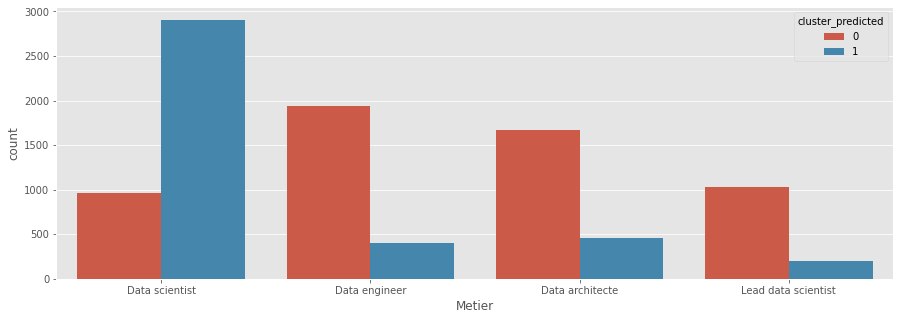

In [54]:
plt.subplots(figsize = (15,5))
sb.countplot(x=combinedDf["Metier"],order=combinedDf["Metier"].value_counts().index,hue=combinedDf['cluster_predicted'])
plt.show()

###### Mise en évidence des profils manquants dans le dataset de départ

In [55]:
# Index des profils manquants
index_nan_metier = list(np.where(combinedDf["Metier"].isnull())[0])
cols = ["cluster_predicted"]

# Métier des profils manquants
pd.concat([df_pret_au_clustering, clustersDf], axis = 1).reset_index().iloc[index_nan_metier][cols]

,cluster_predicted
346,0
2058,0
2670,1
2899,1
3346,0
4248,0
4290,1
4292,0
5425,0
5593,0


### 9) Réaliser la prédiction des métiers manquants dans la base de données par l'algorithme de votre choix
-  Justifier la performance de votre algorithme grace à une métrique.
-  Interpréter votre resultat.  

ExtraTreesClassifier est un algorithme d'apprentissage automatique qui fait partie de la famille des arbres de décision. Je le choisis à cause de ses avantages que sont :

1. Robustesse au bruit : ExtraTreesClassifier est robuste au bruit dans les données d'entrée, ce qui signifie qu'il peut gérer les données avec des erreurs ou des valeurs manquantes sans trop d'effets néfastes sur les performances du modèle.

2. Rapidité : ExtraTreesClassifier est rapide à entraîner et à prédire car il effectue une sélection aléatoire des caractéristiques et utilise des sous-échantillons aléatoires de l'ensemble de données d'entraînement pour construire les arbres de décision.

3. Réduction du surajustement : En utilisant des sous-échantillons aléatoires de l'ensemble de données d'entraînement, ExtraTreesClassifier peut réduire le risque de surajustement, ce qui signifie qu'il est moins susceptible de surapprendre les particularités de l'ensemble de données d'entraînement.

4. Capacité à gérer les données à grande échelle : ExtraTreesClassifier peut facilement gérer les ensembles de données à grande échelle grâce à sa capacité à effectuer des calculs parallèles et distribués.

5. Bonne performance : ExtraTreesClassifier est souvent comparé à d'autres algorithmes de classification en termes de précision et de temps d'exécution, et il a souvent été constaté qu'il donne de très bons résultats en termes de précision.

En résumé, ExtraTreesClassifier est un algorithme puissant qui peut être utilisé pour une variété de tâches de classification et qui présente de nombreux avantages, notamment sa robustesse au bruit, sa rapidité, sa capacité à gérer les données à grande échelle et sa bonne performance.

J'utilise le dataset suivant

In [56]:
df_base = pd.get_dummies(df[["Diplome", "Exp_label"]])
df_for_pred = pd.concat([df["Metier"],df_base,df_Technologies], axis = 1 )
df_for_pred.head()

,Metier,Diplome_Bachelor,Diplome_Master,Diplome_No diploma,Diplome_Phd,Exp_label_Avancé,Exp_label_Confirmé,Exp_label_Débutant,Exp_label_Expert,Aws,...,Java,Linux,Machine learning,Mongodb,Python,R,Sas,Spark,Sql,Vba
0,Data scientist,0,1,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,Data architecte,0,1,0,0,0,1,0,0,0,...,1,0,0,1,1,0,0,0,0,0
2,Lead data scientist,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1,1,0,0,1,0
3,Data scientist,0,1,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
4,Data scientist,0,0,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [57]:
X_des_metiers_manquants = df_for_pred.iloc[index_nan_metier].drop("Metier", axis = 1)
X_des_metiers_manquants.head()

,Diplome_Bachelor,Diplome_Master,Diplome_No diploma,Diplome_Phd,Exp_label_Avancé,Exp_label_Confirmé,Exp_label_Débutant,Exp_label_Expert,Aws,Big data,...,Java,Linux,Machine learning,Mongodb,Python,R,Sas,Spark,Sql,Vba
346,0,0,1,0,0,1,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
2058,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,1,1,0,0,0,1
2670,0,1,0,0,0,0,1,0,0,0,...,1,0,0,0,1,1,0,0,0,0
2899,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,1,1,0,0,0,0
3346,0,1,0,0,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [58]:
df_for_pred_used_to_train = df_for_pred.dropna()

In [59]:
# Separate target and feature
y = df_for_pred_used_to_train["Metier"].astype("category").cat.codes
X = df_for_pred_used_to_train.drop("Metier", axis = 1)

In [60]:
# Création d'un dictionnaire de correspondance entre les labels et les codes de classe
metiers_codes_dict = dict(enumerate(df_for_pred_used_to_train["Metier"].astype('category').cat.categories))
metiers_codes_dict

{0: 'Data architecte',
 1: 'Data engineer',
 2: 'Data scientist',
 3: 'Lead data scientist'}

In [61]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [62]:
# Créer un modèle ExtraTreesClassifier et l'entraîner sur les données d'entraînement
model = ExtraTreesClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

ExtraTreesClassifier(random_state=42)

In [63]:
y_pred = model.predict(X_test)

In [64]:
# Évaluer les performances du modèle avec classification_report et confusion_matrix
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       404
           1       0.93      0.99      0.96       475
           2       0.82      0.91      0.86       780
           3       0.66      0.37      0.48       254

    accuracy                           0.87      1913
   macro avg       0.84      0.80      0.81      1913
weighted avg       0.86      0.87      0.85      1913

Confusion Matrix:


Le rapport de classification indique que le modèle a une précision de 0,96 pour la classe 0, ce qui signifie que 96 %
des métiers prédits comme Data architecte par le modèle étaient effectivement Data architecte.

De même, le modèle a une précision de 0,93 pour la classe 1  , ce qui signifie que 93 % des métiers prédits comme Data engineer par le modèle étaient effectivement Data engineer.

De même, le modèle a une précision de 0,82 pour la classe 2  , ce qui signifie que 82 % des métiers prédits comme Data scientist par le modèle étaient effectivement Data scientist.

Et enfin, le modèle a une précision de 0,66 pour la classe 3  , ce qui signifie que 66 % des métiers prédits comme Lead data scientist par le modèle étaient effectivement Lead data scientist.


Le rappel pour la classe 0 est de 0,94, ce qui signifie que le modèle a identifié 94 % de tous les Data architecte.

Le rappel pour la classe 1 est de 0,99, ce qui signifie que le modèle a identifié 99 % de tous les Data engineer.

Le rappel pour la classe 2 est de 0,91, ce qui signifie que le modèle a identifié 91 % de tous les Data scientist.

Le rappel pour la classe 3 est de 0,37, ce qui signifie que le modèle a identifié 37 % de tous les Lead data scientist.

La mesure F1 est une moyenne harmonique de la précision et du rappel, et elle indique l'équilibre entre la précision et le rappel. 

Enfin, le support est le nombre d'échantillons réels de chaque classe.

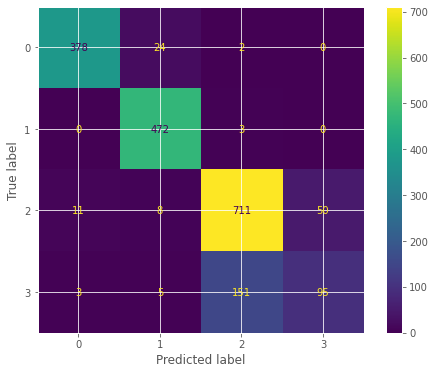

In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(1,1, figsize = (8,6))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(ax = ax)
ax.xaxis.set_ticklabels(['0', '1', '2','3'])
ax.yaxis.set_ticklabels(['0', '1', '2','3'])
#plt.title()
plt.show()

La matrice de confusion est une autre façon d'évaluer les performances d'un modèle de classification. Elle montre le nombre de vrais positifs (VP), de faux positifs (FP), de vrais négatifs (VN) et de faux négatifs (FN) pour chaque classe.

#### Prédiction des métiers manquants

In [66]:
prediction_metiers_manquants = model.predict(X_des_metiers_manquants)
list_pred = list(prediction_metiers_manquants) 
values_list = [metiers_codes_dict[key] for key in list_pred]

metier_predits = pd.DataFrame(list(zip(list_pred, values_list)), columns=['code_metiers', 'Metiers'])

metier_predits

,code_metiers,Metiers
0,1,Data engineer
1,2,Data scientist
2,2,Data scientist
3,2,Data scientist
4,0,Data architecte
5,2,Data scientist
6,2,Data scientist
7,3,Lead data scientist
8,1,Data engineer
9,2,Data scientist


##### Commentaires: